In [29]:
import sys
sys.path.append("C:\\Users\josep\Desktop\sus_packages")
import help_tools1
from help_tools1 import polar_coordinates
from wave_tools import ConstructWave, surface_core, peak_tracking
import wave_tools
#import cv2
import h5py as hf
from matplotlib import cm
#import radar_tools
import numpy as np
#from wave_tools import ConstructWave, surface_core, peak_tracking
#from wave_tools import fft_interpolate, fft_interface, Spectrum
#from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools1 import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools1 import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import math

# 3.2.2 Real Data

In [2]:
#sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
#fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5'

# file with psi = 0 
#f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')


# file with psi = 30 and smax = 30 
#f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_30_smax_30_0_surf3d.hdf5', 'r')

In [3]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [4]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\Extract_around_ADCP_2022011904.hdmf', 'r')

In [5]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

In [6]:
#psi = 0

In [8]:
eta = np.transpose(wamos, (1, 2, 0))
# flips it into correct form (N, N, M)

In [9]:
dx = x[1]-x[0]
dy = y[1]-y[0]
dt = t[1]-t[0]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))

Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [10]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

In [11]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1.0, 1.0]
# Ux current limits [m/s]

Uy_limits = [-1.0, 1.0]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

omegaWidthFun = lambda k: 0.05 + 0.0 * k

In [12]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [13]:
wavenumbers = np.arange(3 * dk, 0.36, dk)
wavenumbers

array([0.03807991, 0.05077321, 0.06346652, 0.07615982, 0.08885313,
       0.10154643, 0.11423973, 0.12693304, 0.13962634, 0.15231964,
       0.16501295, 0.17770625, 0.19039955, 0.20309286, 0.21578616,
       0.22847947, 0.24117277, 0.25386607, 0.26655938, 0.27925268,
       0.29194598, 0.30463929, 0.31733259, 0.33002589, 0.3427192 ,
       0.3554125 ])

### Define Functions

In [14]:
h = np.inf
g = 9.81
T = 0.072 / 1000

In [15]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum

In [16]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    
    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers)}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    return out_fit

In [17]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/max(a))**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/max(a))**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G

In [18]:
wavenumberLimits = []

for jj in range(len(wavenumbers)):
    wavenumberLimits_range = wavenumbers[jj] + kW * np.array([-1,1])
    wavenumberLimits.append(wavenumberLimits_range)

In [19]:
Spectrum_at_k = []

ind_x_at_k = []
ind_y_at_k = []
ind_w_at_k = []

W_3D_at_k = []
Kx_3D_at_k = []
Ky_3D_at_k = []

Ux_at_k = []
Uy_at_k = []

SNR_max_at_k = []

snrG_at_k = []

im_at_k = []
cDoppGuess_at_k = []

Ux_at_k_correct = []
Uy_at_k_correct = []

# Initialize the tqdm progress bar outside the loop
progress_bar = tqdm(total=len(wavenumberLimits), desc="Processing wavenumbers")

for i in range(len(wavenumberLimits)):
    # i is the index of each wavenumber
    
    fit_param = {'wavenumbers': wavenumbers[i],
     'include2ndHarmonic': 0,
     'logFlag': [],
     'SNR_filter': 0,
     'SNR_threshold': 1.0,
     'Peak_filter': 0,
     'Peak_threshold': 0.5,
     'Outlier_filter': 0,
     'kWidth': 0.050015405430285265,
     'Ux_2D': Uxm, 
     'Uy_2D': Uym}
    
    P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}
    
    Spectrum = retrieve_power_spectrum(eta, dx, dy, dt, K_limits=wavenumberLimits[i], W_limits=frequencyLimits)
    Spectrum_at_k.append(Spectrum)
    
    Nt, Nx, Ny = eta.shape
    
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values
    # w = spec3d.get_C()[0]
    # Kx = spec3d.get_C()[1]
    # Ky = spec3d.get_C()[2]
    
    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    # kx, ky and w resolution
    
    Norm = dKx * dKy * dW
    
    # Get power spectra (1200, 67, 67)
    Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2
    # ?? how is this related to FFT spec3d.spectrum()
    
    ind_x = np.abs(Kx) <= wavenumberLimits[i][1]
    ind_x_at_k.append(ind_x)
    ind_y = np.abs(Ky) <= wavenumberLimits[i][1]
    ind_y_at_k.append(ind_y)
    # Is the absolute values of Kx and Ky smaller than the upper value of the wavenumber range 
    
    ind_w = (w >= frequencyLimits[0]) & (w <= frequencyLimits[1])
    ind_w_at_k.append(ind_w)
    # Is the value of w between the frequency limits 0.01 and 20 
    
    # Create 3D structure where it only includes w,Kx,Ky that are in the ranges required by wavenumberLimits
    W_3D, Kx_3D, Ky_3D = np.meshgrid( w[ind_w_at_k[i]], Kx[ind_x_at_k[i]] , Ky[ind_y_at_k[i]] , indexing='ij')
    W_3D_at_k.append(W_3D)
    Kx_3D_at_k.append(Kx_3D)
    Ky_3D_at_k.append(Ky_3D)
    
    
    Ux_2D = Uxm
    Uy_2D = Uym
    
    snrG = np.zeros(Ux_2D.shape)
    
    for m in range(Ux_2D.shape[0]):
        for n in range(Ux_2D.shape[1]):
            snr_mn, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers[i], Ux_2D[m, n], Uy_2D[m, n])
            snrG[m, n] = snr_mn
            
            
    snrG_at_k.append(snrG)
    # Append the 2D array to the list
    
    
    im = np.argmax(snrG_at_k[i])
    im_at_k.append(im)
    
    if np.ndim(Ux_2D) == 1:
        cDoppGuess = Ux_2D[im]
    else:
        Ux_1D = Ux_2D.flatten()
        Uy_1D = Uy_2D.flatten()
        cDoppGuess = [Ux_1D[im], Uy_1D[im]]
    
    cDoppGuess_at_k.append(cDoppGuess)
    
    
    Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], cDoppGuess)
    
    Ux = Ufit.x[0]
    Uy = Ufit.x[1]
    
    Ux_at_k_correct.append(Ux)
    Uy_at_k_correct.append(Uy)
    
    # Update the tqdm progress bar
    progress_bar.update(1)

# Close the tqdm progress bar after the loop is finished
progress_bar.close()

Processing wavenumbers: 100%|██████████| 26/26 [01:48<00:00,  4.16s/it]


In [20]:
Ux = np.array(Ux_at_k_correct)
Uy = np.array(Uy_at_k_correct)

(0.0, 0.36)

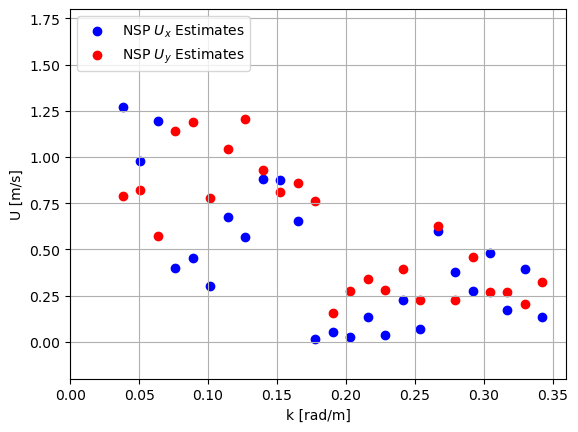

In [36]:
plt.scatter(wavenumbers[:-1], np.abs(Ux[:-1]), label='NSP $U_x$ Estimates', color = 'blue')
plt.scatter(wavenumbers[:-1], np.abs(Uy[:-1]), label='NSP $U_y$ Estimates', color = 'red')
#plt.plot(k, Uk[:,0]*np.cos(math.radians(psi)), label = 'Correct $U_x$', linestyle='--', color='black')
#plt.plot(k, Uk[:,0]*np.sin(math.radians(psi)), label = 'Correct $U_y$', linestyle='-', color='black')

plt.grid(True)
plt.legend(loc = 'upper left')
plt.ylabel("U [m/s]")
plt.xlabel("k [rad/m]")
#plt.title(f"$\psi = {psi}\degree$")

plt.ylim(-0.2, 1.8)
plt.xlim(0, 0.36)

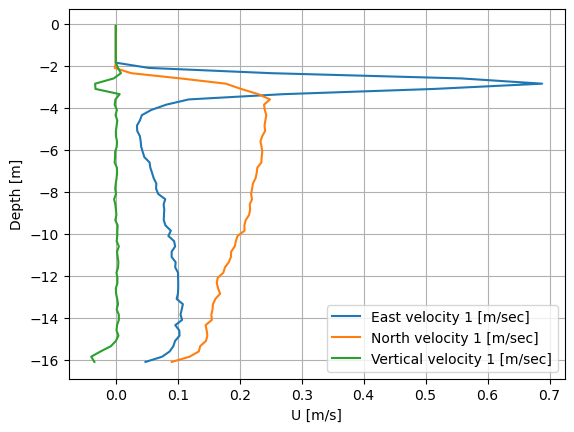

In [33]:
hf1 = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Archiv\ADCP_2022011904.mat', 'r')
east_vel1 = np.array(hf1['East_vel'])
north_vel1 = np.array(hf1['North_vel'])
vertical_vel1 = np.array(hf1['Vertical_vel'])
z1 = np.array(hf1['z_vec'])
t1 = hf1['time_vec'][()]
#hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean1 = np.mean(east_vel1[start_i:stop_i], axis=0)
north_vel_mean1 = np.mean(north_vel1[start_i:stop_i], axis=0)
vertical_vel_mean1 = np.mean(vertical_vel1[start_i:stop_i], axis=0)

fig, ax = plt.subplots()
ax.plot(east_vel_mean1, z1, label='East velocity 1 [m/sec]')
ax.plot(north_vel_mean1, z1, label='North velocity 1 [m/sec]')
ax.plot(vertical_vel_mean1, z1, label='Vertical velocity 1 [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()
plt.grid(True)
plt.show()

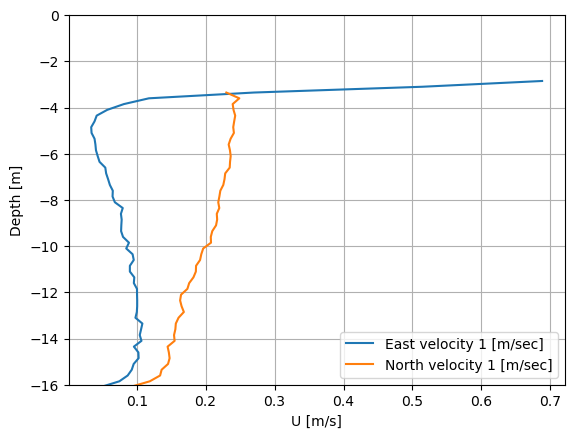

In [49]:
fig, ax = plt.subplots()
ax.plot(east_vel_mean1[:54], z1[:54], label='East velocity 1 [m/sec]')
ax.plot(north_vel_mean1[:52], z1[:52], label='North velocity 1 [m/sec]')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend(loc = 'lower right')
plt.grid(True)
plt.ylim(-16, 0)
plt.show()

### North velocity

In [50]:
def fexp(x,a,b,c):
    """Exponential function with no offset"""
    return a*x**b + c

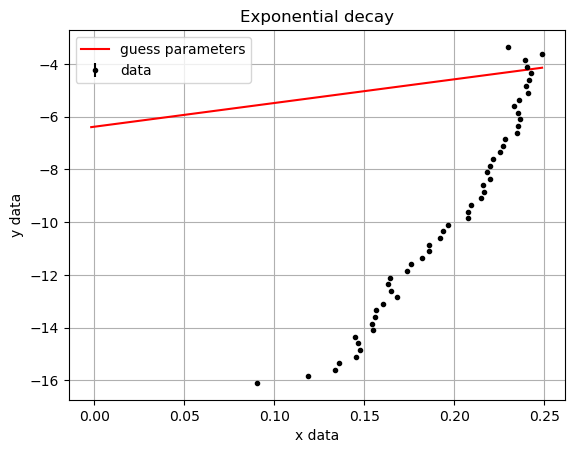

In [57]:
# plot the raw data
plt.errorbar(north_vel_mean1[:52], z1[:52].flatten(), yerr=0, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('x data')
plt.ylabel('y data')


# initial guess
pars0 = (9, 1, -6.38)

# overlay exponential 

x = np.linspace(min(north_vel_mean1), max(north_vel_mean1), 100)

plt.plot(x, fexp(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Exponential decay");

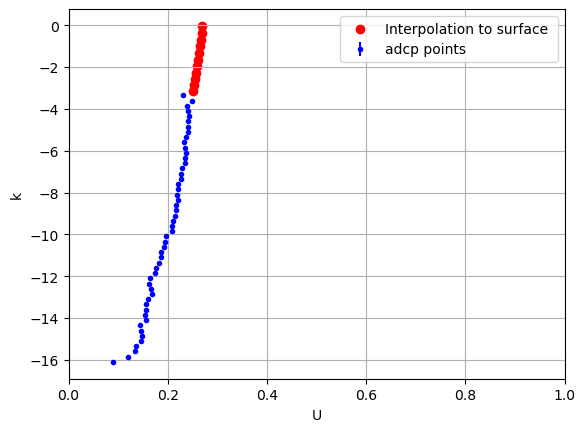

In [76]:
# perform fitting
popt, pcov = curve_fit(fexp, north_vel_mean1[:52], z1[:52].flatten(),  absolute_sigma=True, p0=pars0, maxfev = 2000)

# plot data
plt.errorbar(north_vel_mean1[:52], z1[:52].flatten(), yerr=0, fmt=".", color = 'blue', label = 'adcp points')

# creating x interval to include in y fit
x = np.linspace(min(north_vel_mean1[:52]), max(north_vel_mean1[:52])+0.0208, 100)
y_fit = fexp(x, *popt)
plt.scatter(x[89:], y_fit[89:], color="red", label="Interpolation to surface ")

#plt.ylim(-17, 0)
plt.xlim(0,1)


plt.grid(True)
plt.xlabel("U")
plt.ylabel("k")
plt.legend();

In [77]:
interpolated_U = np.concatenate((north_vel_mean1[:52], x[89:]))
interpolated_z = np.concatenate((z1[:52].flatten(), y_fit[89:]))

In [81]:
stew_joy_interp_north = []
k_north = np.linspace(0.01, 0.35, 40)

for i in range(len(k_1)):
    integral = 2 * k_north[i] * np.trapz(interpolated_U *np.e**(2*k_north[i]*interpolated_z), x=interpolated_z)
    stew_joy_interp_north.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array_north = np.array(stew_joy_interp_north)

(0.0, 0.5)

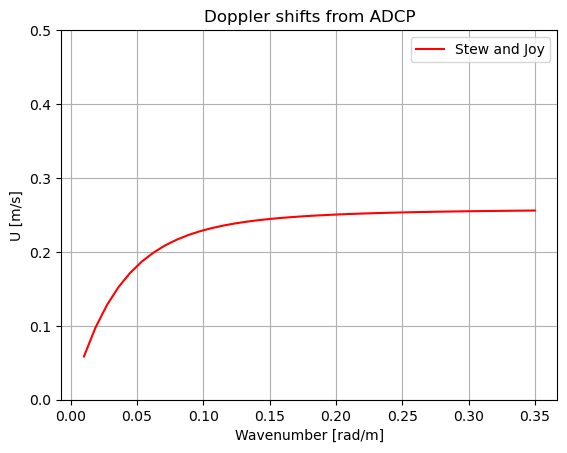

In [83]:
#plt.plot(k_1, stew_joy_ineterp_array, label = 'interpolated line fit', linestyle='--', color='blue')
plt.plot(k_1, stew_joy_ineterp_array_1, label = 'Stew and Joy', linestyle='-', color='red')

#plt.plot(k_1, stew_joy_ineterp_array_findepth, label = 'Finite depth version ', linestyle='--', color='blue')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts from ADCP")

plt.ylim(0, 0.5)

### East velocity

In [84]:
no = np.argmax(east_vel_mean1)

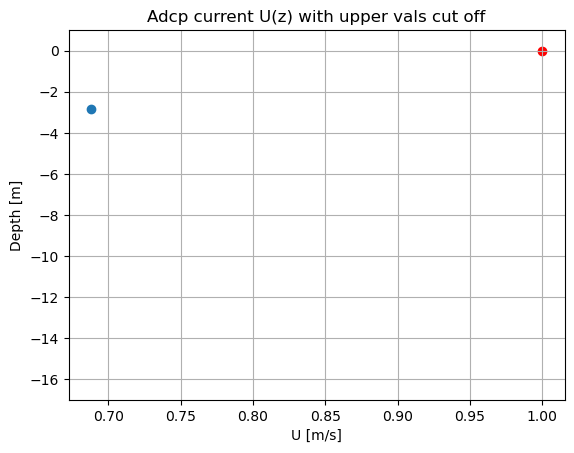

In [86]:
plt.scatter(east_vel_mean1[no], z1[no], label='East velocity [m/sec]')

plt.scatter(1, 0, color = 'red', label = 'maximum point assumption')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,1)
#plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

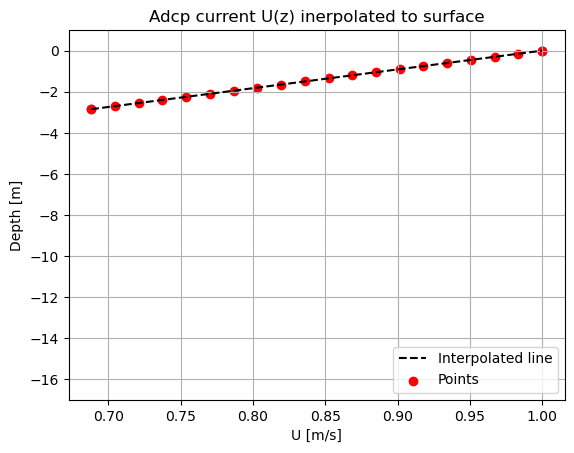

In [87]:
# Define the number of points you want to interpolate
num_points = 20  # Adjust this as needed

# Interpolate the points
x_line = np.linspace(east_vel_mean1[no], 1, num_points)
y_line = np.linspace(z1[no], 0, num_points)

# Plot the scatter plot of the data points
plt.scatter(east_vel_mean1[no], z1[no])
plt.scatter(1, 0, color='blue')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17, 1)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) inerpolated to surface")
plt.show()


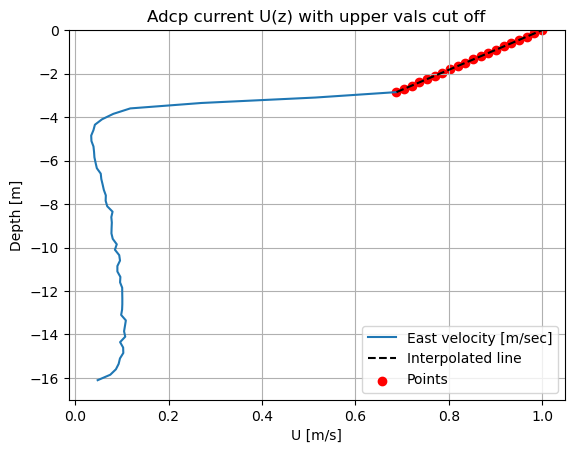

In [92]:
plt.plot(east_vel_mean1[:54], z1[:54], label='East velocity [m/sec]')

# Interpolate a straight line between the points
plt.plot(x_line, y_line, 'k--', label='Interpolated line')

# Plot the equally spaced points
plt.scatter(x_line, y_line, color='red', label='Points')

plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-17,0)
plt.legend(loc='lower right')
plt.grid(True)

plt.title("Adcp current U(z) with upper vals cut off")
plt.show()

In [94]:
new_interpolated_z = np.concatenate((z1[:54].flatten(), y_line.flatten()))
new_interpolated_U = np.concatenate((east_vel_mean1[:54] , x_line))


In [96]:
stew_joy_interp_east = []
k_east = np.linspace(0.01, 0.35, 40)

for i in range(len(k_east)):
    integral = 2 * k_1[i] * np.trapz(new_interpolated_U *np.e**(2*k_1[i]*new_interpolated_z), x=new_interpolated_z)
    stew_joy_interp_east.append(integral)
# Evaluates Stewart and Joy integral 

stew_joy_ineterp_array_east = np.array(stew_joy_interp_east)

Text(0.5, 1.0, 'Doppler shifts from ADCP')

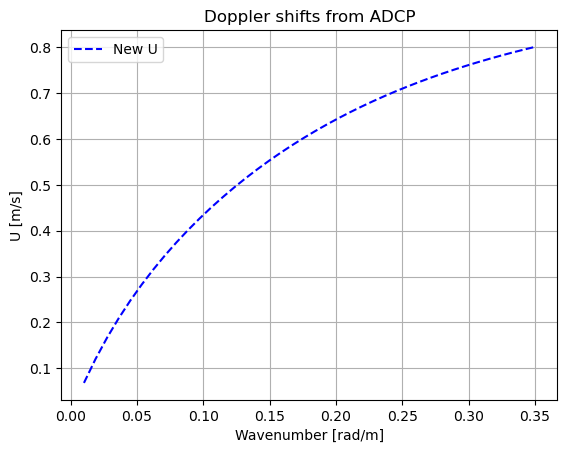

In [97]:
plt.plot(k_east, stew_joy_ineterp_array_east, label = 'New U', linestyle='--', color='blue')
#plt.plot(orig_k, orig_U, label = 'Correct U - original fitting', linestyle='-', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("Doppler shifts from ADCP")

(0.0, 0.36)

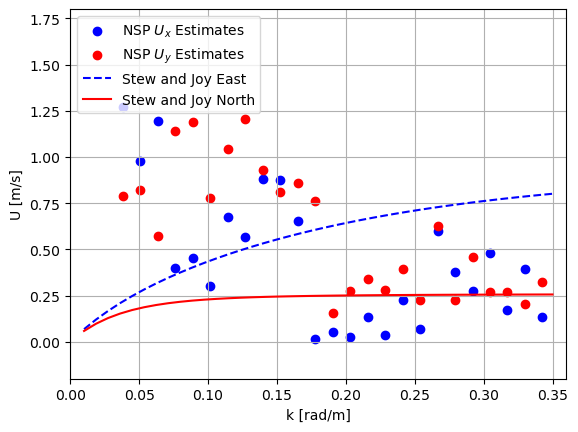

In [100]:
plt.scatter(wavenumbers[:-1], np.abs(Ux[:-1]), label='NSP $U_x$ Estimates', color = 'blue')
plt.scatter(wavenumbers[:-1], np.abs(Uy[:-1]), label='NSP $U_y$ Estimates', color = 'red')
#plt.plot(k, Uk[:,0]*np.cos(math.radians(psi)), label = 'Correct $U_x$', linestyle='--', color='black')
#plt.plot(k, Uk[:,0]*np.sin(math.radians(psi)), label = 'Correct $U_y$', linestyle='-', color='black')

plt.plot(k_east, stew_joy_ineterp_array_east, label = 'Stew and Joy East', linestyle='--', color='blue')
plt.plot(k_1, stew_joy_ineterp_array_1, label = 'Stew and Joy North', linestyle='-', color='red')



plt.grid(True)
plt.legend(loc = 'upper left')
plt.ylabel("U [m/s]")
plt.xlabel("k [rad/m]")
#plt.title(f"$\psi = {psi}\degree$")

plt.ylim(-0.2, 1.8)
plt.xlim(0, 0.36)

# RMS Calculation

In [26]:
# Assuming wavenumbers and Uk are numpy arrays
matched_Ux = []
matched_kx = []

for wavenumber in wavenumbers[:-1]:
    closest_index = np.argmin(np.abs(k - wavenumber))
    matched_Ux.append(Uk[closest_index, 0]*np.cos(math.radians(psi)))
    matched_kx.append(k[closest_index])  # Record the closest wavenumber from k

# Convert lists to numpy arrays if needed
matched_Ux = np.array(matched_Ux)
matched_kx = np.array(matched_kx)

(0.0, 0.36)

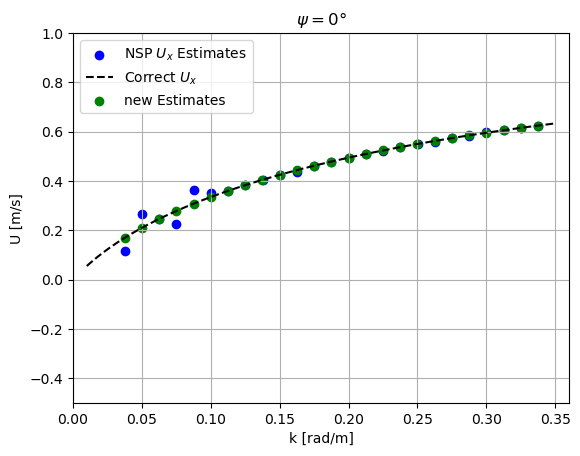

In [27]:
plt.scatter(wavenumbers[:-1], -Ux[:-1], label='NSP $U_x$ Estimates', color = 'blue')
plt.plot(k, Uk[:,0]*np.cos(math.radians(psi)), label = 'Correct $U_x$', linestyle='--', color='black')
plt.scatter(matched_kx, matched_Ux, label='new Estimates', color = 'green')

plt.grid(True)
plt.legend(loc = 'upper left')
plt.ylabel("U [m/s]")
plt.xlabel("k [rad/m]")
plt.title(f"$\psi = {psi}\degree$")

plt.ylim(-0.5, 1)
plt.xlim(0, 0.36)

In [28]:
# Assuming wavenumbers and Uk are numpy arrays
matched_Uy = []
matched_ky = []

for wavenumber in wavenumbers[:-1]:
    closest_index = np.argmin(np.abs(k - wavenumber))
    matched_Uy.append(Uk[closest_index, 0]*np.sin(math.radians(psi)))
    matched_ky.append(k[closest_index])  # Record the closest wavenumber from k

# Convert lists to numpy arrays if needed
matched_Uy = np.array(matched_Uy)
matched_ky = np.array(matched_ky)

(0.0, 0.36)

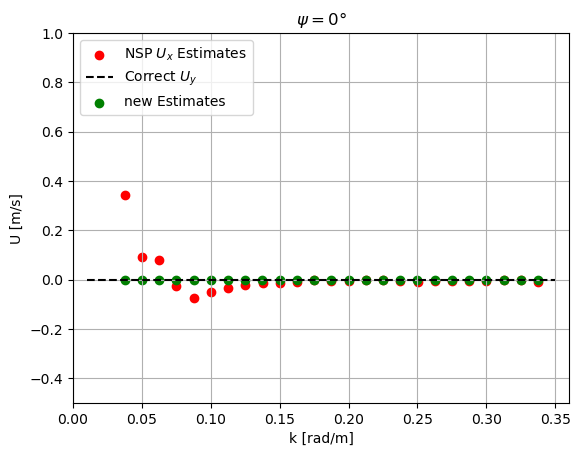

In [30]:
plt.scatter(wavenumbers[:-1], Uy[:-1], label='NSP $U_x$ Estimates', color = 'red')
plt.plot(k, Uk[:,0]*np.sin(math.radians(psi)), label = 'Correct $U_y$', linestyle='--', color='black')
plt.scatter(matched_ky, matched_Uy, label='new Estimates', color = 'green')

plt.grid(True)
plt.legend(loc = 'upper left')
plt.ylabel("U [m/s]")
plt.xlabel("k [rad/m]")
plt.title(f"$\psi = {psi}\degree$")

plt.ylim(-0.5, 1)
plt.xlim(0, 0.36)

In [22]:
def rms(x):
    return np.sqrt((x**2))

In [23]:
rms_Ux = rms( -Ux[:-1] - matched_Ux)
rms_Uy = rms( -Uy[:-1] - matched_Uy)

(0.0, 0.36)

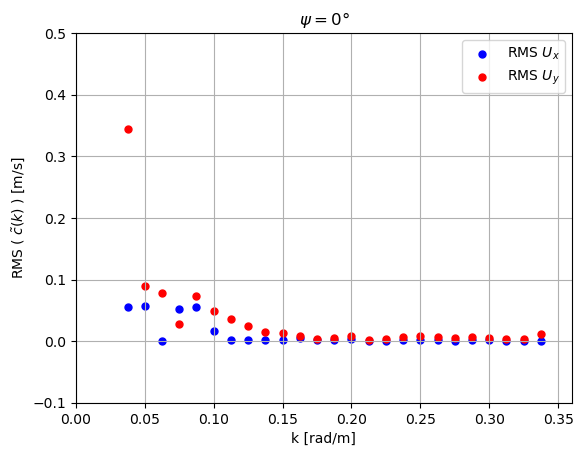

In [24]:
plt.scatter(matched_kx, rms_Ux, label='RMS $U_x$', color = 'blue', s = 25)
plt.scatter(matched_ky, rms_Uy, label='RMS $U_y$', color = 'red', s = 25)

plt.grid(True)
plt.legend(loc = 'upper right')
plt.ylabel("RMS ( $\\tilde{c}(k)$ ) [m/s]")
plt.xlabel("k [rad/m]")
plt.title(f"$\psi = {psi}\degree$")

plt.ylim(-0.1, 0.5)
plt.xlim(0, 0.36)